# LSTM: Many-to-many setup

In [100]:
import re
import numpy as np
import unidecode
from keras.preprocessing.sequence import pad_sequences
from IPython import get_ipython;   
#get_ipython().magic('reset -sf')
import pandas
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout,Softmax,Flatten,concatenate
from keras.layers import LSTM
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from IPython.display import Image

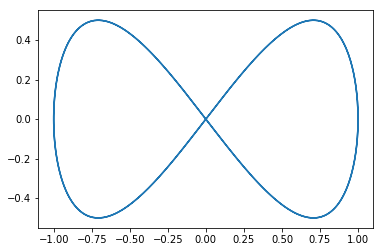

In [101]:
thetas = np.linspace(0,4*np.pi,1000)
dataset = np.array([np.sin(thetas),np.sin(thetas)*np.cos(thetas)]).T
dataset = dataset.astype('float32')
plt.plot(dataset[:,0],dataset[:,1])
plt.show()

In [102]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_back):
        print
        a = dataset[i:(i+look_back), :]
        b = dataset[(i+look_back):(i+look_back+look_back),:]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [103]:
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
trainX.shape,trainY.shape

((630, 20, 2), (630, 20, 2))

In [118]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def goal_model(traj_input_shape,goal_input_shape, hidden_dim,n_outputs):
    
    # Input to lstm
    lstm_input = Input(shape=(traj_input_shape),name="input_trajectory")
    
    # LSTM unit
    lstm = LSTM(hidden_dim,return_state=True,name="lstm_unit")
    
    # LSTM outputs
    lstm_outputs, state_h, state_c = lstm(lstm_input)
    
    # Input for goals
    goals_input = Input(shape=(goal_input_shape),name="goal_input")
    
    # Merge inputs with LSTM features
    concat_input = concatenate([goals_input,lstm_outputs],name="stacked_input")
    
    # Final FC layer with a softmax activation
    goal_output = Dense(n_outputs,activation="softmax",name="goal_output")(concat_input)
        
    # Create final model
    model = Model([lstm_input,goals_input], goal_output)
    
    # Compile model using loss
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

def trajectory_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs):

    # Input to lstm
    lstm_input = Input(shape=(traj_input_shape),name="trajectory_input")
    
    # LSTM unit
    lstm = LSTM(hidden_dim,return_state=True,name="lstm_unit")
    
    # LSTM outputs
    lstm_outputs, state_h, state_c = lstm(lstm_input)
    encoder_states = [state_h,state_c]
    
    # Input for goals
    goals_input = Input(shape=(goal_input_shape),name="goal_input")
    
    # Repeat the goal inputs
    goals_repeated= RepeatVector(n_outputs)(goals_input)
    
    # Define decoder
    decoder = LSTM(hidden_dim,return_sequences=True, return_state=True)
    
    # Decoder outputs, initialize with previous lstm states
    decoder_outputs,_,_ = decoder(goals_repeated,initial_state=encoder_states)
    
    # Shape to a time series prediction of n_outputs x features
    decoder_fully_connected = TimeDistributed(Dense(n_outputs))(decoder_outputs)
    
    # Create final model
    model = Model([lstm_input,goals_input], decoder_fully_connected)
    
    # Compile model using loss
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model
    

In [162]:
traj_input_shape=(20,2)
goal_input_shape=(32*3,)
hidden_dim = 20
n_outputs = 10
model = goal_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs)
traj_model = trajectory_model(traj_input_shape,goal_input_shape,hidden_dim,n_outputs)
plot_model(model,to_file='model.png')
plot_model(traj_model,to_file='traj_model.png')
display(HTML("<table><tr><td><img src='model.png'></td><td><img src='traj_model.png'></td></tr></table>"))

,


In [68]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def create_encoder(X_seq_len,X_seq_feat,Y_seq_len,Y_seq_feat, hidden_dim):
    # Set up input shape to encoder
    encoder_input_layer = Input(shape=(X_seq_len,X_seq_feat))
    
    # Define encoder
    encoder = LSTM(hidden_dim,return_state=True)
    # Encoder outputs - but only consider the memory and weights
    encoder_outputs, state_h, state_c = encoder(encoder_input_layer)
    
    goal_input_layer = Input(shape=(32,))
    
    
    encoder_input = concatenate([state_h,state_c,goal_input_layer])
    
    FC = Dense(33,activation='softmax')(encoder_input)
        
    # Create final model
    model = Model([encoder_input_layer,goal_input_layer], FC)
    
    # Compile model using loss
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model
    

In [102]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def create_decoder(X_seq_len,X_seq_feat,Y_seq_len,Y_seq_feat, hidden_dim):
    
    
    decoder_input = Input(shape=(53,))
    decoder_fc = Dense((2*hidden_dim))(decoder_input)
    decoder_shape = Reshape((2,hidden_dim))(decoder_fc)
    
    
    
    
    
    
    # We need to feed the decoder some zero inputs that is uncorrelated
    null_input = Input(shape=[Y_seq_feat])
    repeated_null = RepeatVector(Y_seq_len)(null_input)
    
    # Define decoder
    decoder = LSTM(hidden_dim,return_sequences=True, return_state=True)
    decoder_outputs,_,_ = decoder(repeated_null,initial_state=[decoder_shape[0],decoder_shape[1]])
    decoder_fully_connected = TimeDistributed(Dense(Y_seq_feat))(decoder_outputs)
        
    # Create final model
    model = Model([decoder_input,null_input], decoder_fully_connected)
    
    # Compile model using loss
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model
    

In [103]:
input_len = 20
input_feat = 2
output_len = 20
output_feat = 2
hidden_dim = 20
model = create_model(input_len,input_feat,output_len,output_feat,hidden_dim)
#print(model.summary())
encoder = create_encoder(input_len,input_feat,output_len,output_feat,hidden_dim)
decoder = create_decoder(input_len,input_feat,output_len,output_feat,hidden_dim)
#print(encoder.summary())
print(decoder.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_132 (InputLayer)       (None, 2)                 0         
_________________________________________________________________
repeat_vector_26 (RepeatVect (None, 20, 2)             0         
_________________________________________________________________
lstm_86 (LSTM)               [(None, 20, 20), (None, 2 1840      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 20, 2)             42        
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
input_len = 20
input_feat = 2
output_len = 20
output_feat = 2
hidden_dim = 20
model = create_model(input_len,input_feat,
                     output_len,output_feat,hidden_dim)
print(model.summary())
x = trainX[:,:,:]
y = trainY[:,:,:]
z = np.zeros((len(x),output_feat))
#model.fit([x,z],y,epochs=100)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 20, 2)        0                                            
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 20, 2)        0           input_34[0][0]                   
__________________________________________________________________________________________________
lstm_26 (LSTM)                  [(None, 20), (None,  1840        input_33[0][0]                   
__________________________________________________________________________________________________
lstm_27 (L

In [8]:
xp = model.predict([x,z])

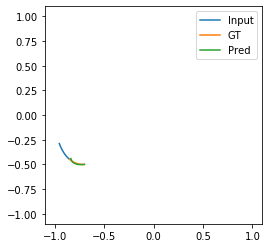

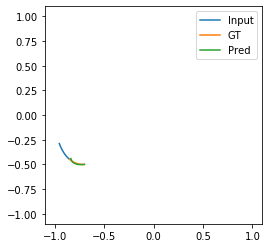

In [9]:
line, = plt.plot([],[],label='Input')
line1, = plt.plot([],[],label='GT')
line2, = plt.plot([],[],label='Pred')
plt.legend()
ax = plt.gca()
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')
for i in range(400):
    line.set_data(trainX[i,:,0],trainX[i,:,1])
    line1.set_data(trainY[i,:,0],trainY[i,:,1])
    line2.set_data(xp[i,:,0],xp[i,:,1])
    display.clear_output(wait=True)
    display.display(plt.gcf()) 